
# The structure of this jupyter notebook:
1. Load model
2. Solve model
3. Simulate model
4. Plot model results 

    i. Average over age

    ii. All simulation over age

    iii. Solutions for each grid point over age (2D)
    
    iV. solutions for specific grid points in 3D

5. Welfare analysis
     
    i. Replacement rate

    ii. Consumption replacement rate

    iii. Consumption equivalence

# Load model 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *

In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

Plot s-grid

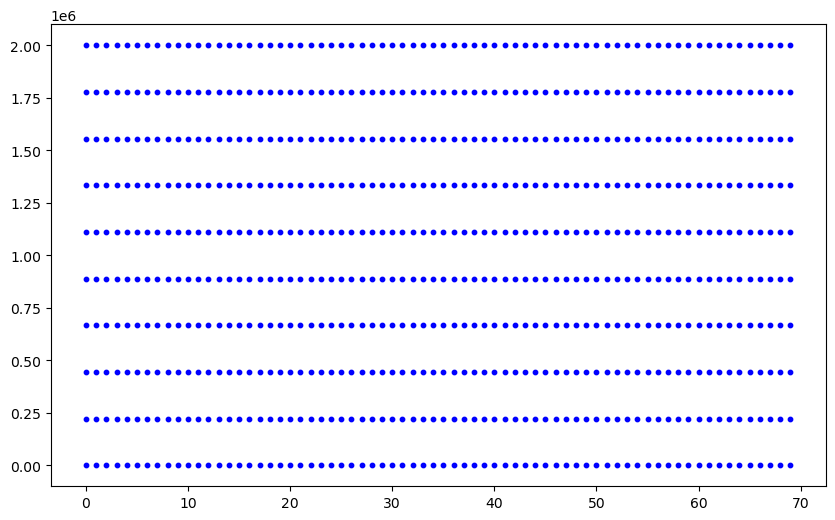

In [3]:
grid = np.concatenate(par.s_grid).reshape(70, 10)
time = np.arange(grid.shape[0])

# Scatter plot for each column
plt.figure(figsize=(10, 6))
for i in range(grid.shape[1]):
    plt.scatter(time, grid[:, i], color='blue', s=10)

# Solve model

In [4]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=True)

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

# Simulate model

In [5]:
%time model.simulate()

CPU times: total: 5.16 s
Wall time: 12.5 s


# Plot model results

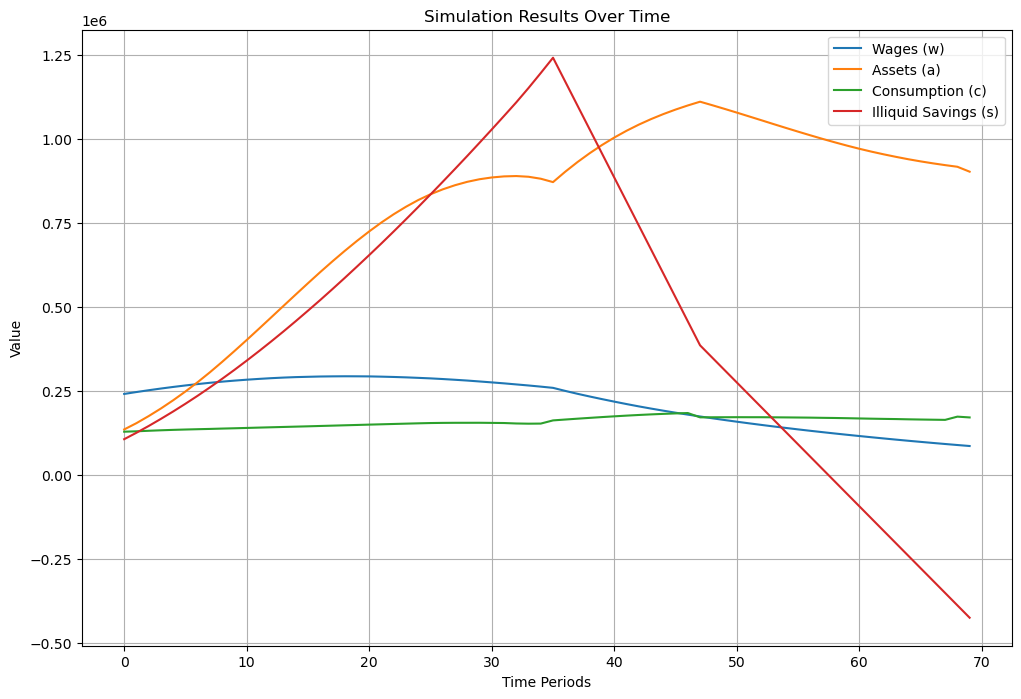

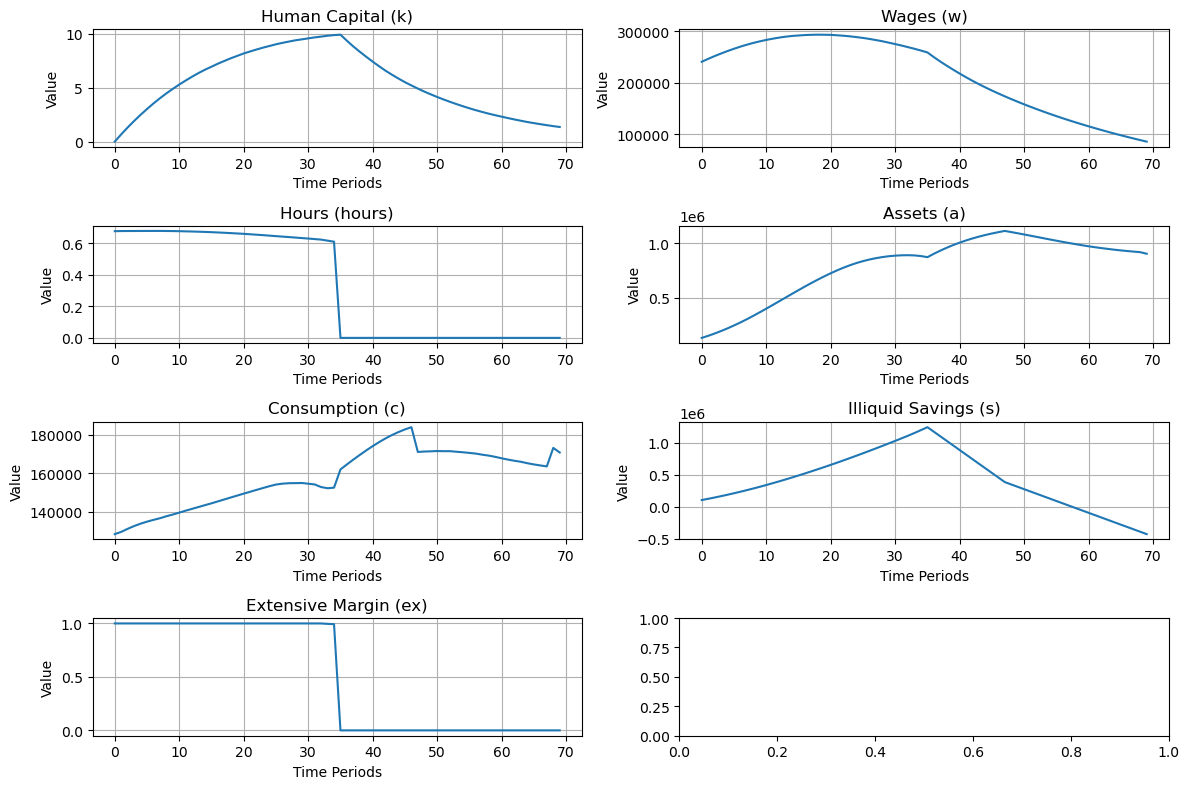

In [6]:
time = np.arange(par.T)

simulated_data = {
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
}

# Create a figure and plot each variable
plt.figure(figsize=(12, 8))
for label, data in simulated_data.items():
    plt.plot(time, data, label=label)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
data_dict = {
    "Human Capital (k)": np.mean(model.sim.k[:], axis=0),
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Hours (hours)": np.mean(model.sim.h[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(model.sim.ex[:], axis=0),
}
# Plot each variable in its respective subplot
for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
    ax.plot(time, data)
    ax.set_title(label)
    ax.set_xlabel("Time Periods")
    ax.set_ylabel("Value")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


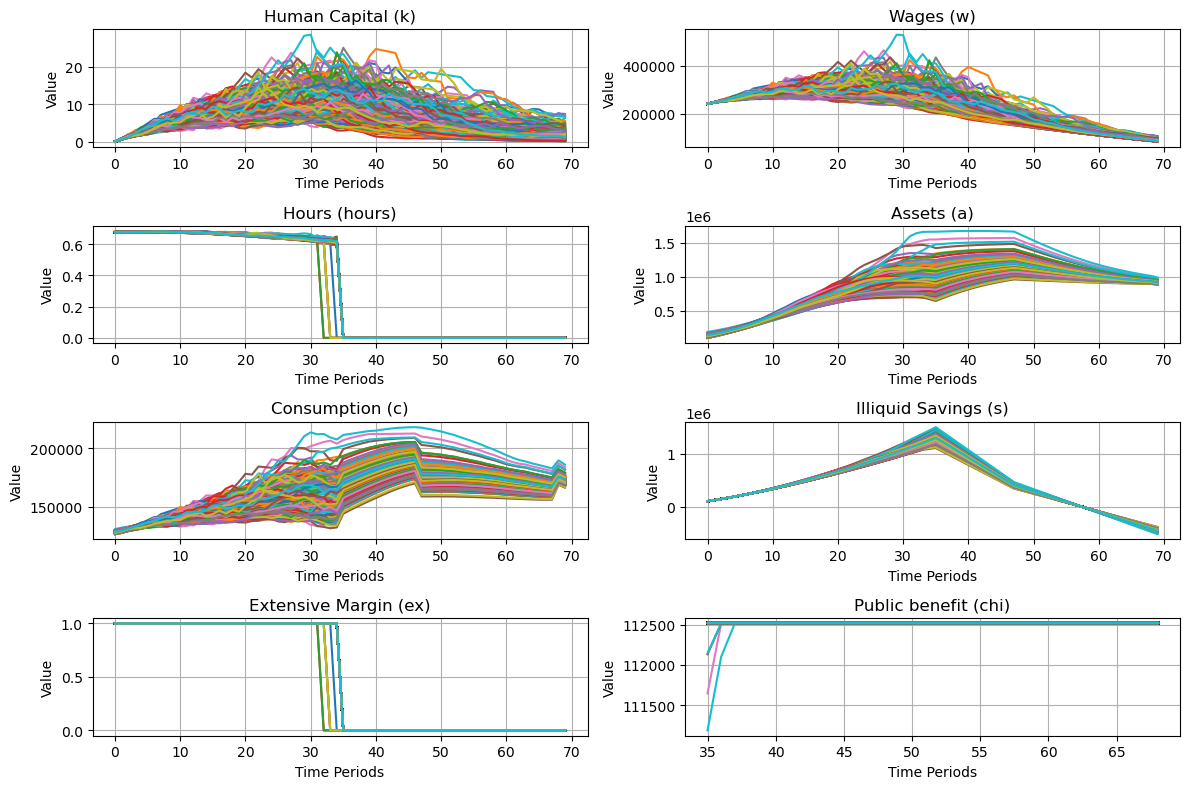

In [7]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
for i in range(1000):
    data_dict = {
        "Human Capital (k)": model.sim.k[i,:],
        "Wages (w)": model.sim.w[i,:],
        "Hours (hours)": model.sim.h[i,:],
        "Assets (a)": model.sim.a[i,:],
        "Consumption (c)": model.sim.c[i,:],
        "Illiquid Savings (s)": model.sim.s[i,:],
        "Extensive Margin (ex)": model.sim.ex[i,:],
        "Public benefit (chi)": model.sim.chi_payment[i,:],
    }
    # Plot each variable in its respective subplot
    for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
        ax.plot(time, data)
        ax.set_title(label)
        ax.set_xlabel("Time Periods")
        ax.set_ylabel("Value")
        ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

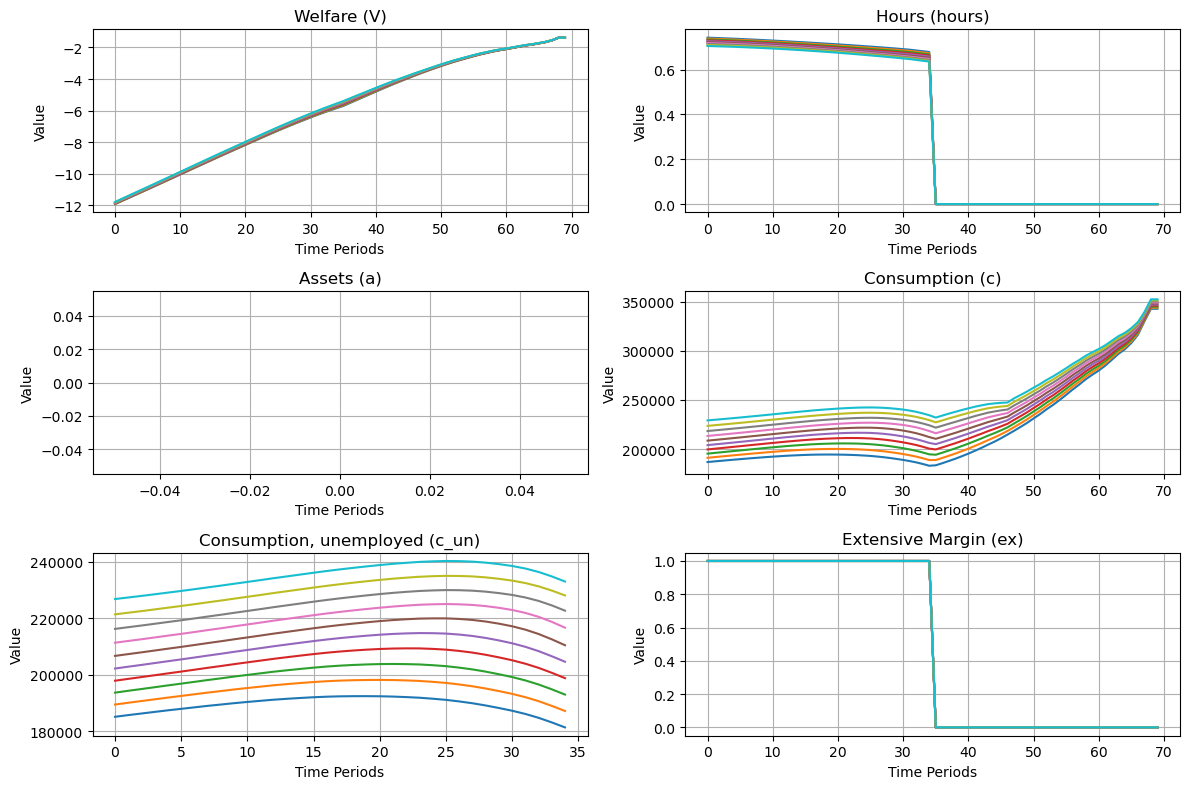

In [8]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
for s in range(par.N_s):
    for k in range(par.N_k):
        for a in range(par.N_a):
            data_dict = {
                "Welfare (V)": model.sol.V[:,a,s,k],
                "Hours (hours)": model.sol.h[:,a,s,k],
                "Assets (a)": model.sol.a[:,a,s,k],
                "Consumption (c)": model.sol.c[:,a,s,k],
                "Consumption, unemployed (c_un)": model.sol.c_un[:,a,s,k],
                "Extensive Margin (ex)": model.sol.ex[:,a,s,k],
            }
    # Plot each variable in its respective subplot
    for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
        ax.plot(time, data)
        ax.set_title(label)
        ax.set_xlabel("Time Periods")
        ax.set_ylabel("Value")
        ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B465929\AppData\Local\Temp\ipykernel_16400\3052429392.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')
C:\Users\B465929\AppData\Local\Temp\ipykernel_16400\3052429392.py:24: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')
C:\Users\B465929\AppData\Local\Temp\ipykernel_16400\3052429392.py:18: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at 

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10, 700) and arg 2 with shape (10, 10).

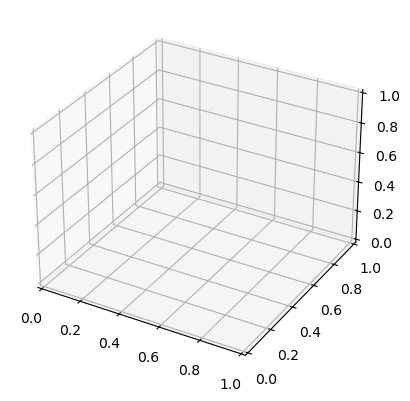

In [9]:
# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()


# Welfare, 
1. Replacement rate
2. Consumption replacement rate
3. Calculate consumption equivalence

In [ ]:
# calculate replacement rate
replacement_rate = replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Replacement Rate Distribution")
plt.xlabel("Replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

In [ ]:
consumption_replacement_rate = consumption_replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(consumption_replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Consumption replacement Rate Distribution")
plt.xlabel("Consumption replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

In [ ]:
theta = [40]
theta_names = ['retirement_age']
find_consumption_equivalence(model,theta,theta_names, do_print=True)
